# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 44

**Author 1 (sciper):** Paul Véronique Guillaume DEVIANNE (311030)

**Author 2 (sciper):** Rizhong LIN (366842)

**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 8.03.2023  

**Due date:** 24.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
print(data_base_path)
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))

with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

../data


---
## Part 1: Segmentation


### 1.0 Intro

In this exercise, you will be given two images.

* `mucinous_adeno.jpg`: The image depicts a tissue sample from mucinous adenocarcinoma in colorectal cancer. The data is taken from the Cancer Genome Atlas (TCGA) which is an open-source database of different cancer types. Here you can see a tissue taken from a patient and stained using hematoxylin (purple) and eosin (pink) staining. The hematoxylin stains cell nuclei with a purplish blue, and the eosin stains the extracellular matrix and cytoplasm in pink.

* `mucinous_adeno_gt.jpg`: The second image is a coarse annotation of what is regarded as the so-called mucinous area. The mucinous area can be identified as a gray area tainted with purple. The presence of a large amount of mucin is a sign of a defect of normal epithelial cells that start to produce an unreasonable amount of mucin.


### 1.1 Tasks

You will be asked to extract the mucinous area using various approaches:

- [ ] Thresholding
- [ ] Morphology
- [ ] Region growing


### 1.1 Brain image visualization

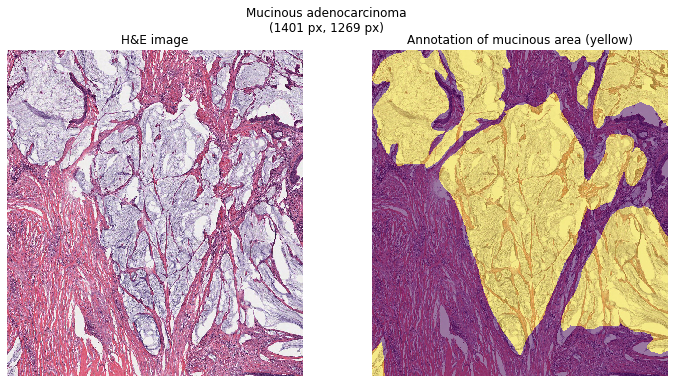

In [2]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load images
path_to_image = os.path.join(data_base_path, data_folder, "mucinous_adeno.jpg")
path_to_gt = os.path.join(data_base_path, data_folder, "mucinous_adeno_gt.jpg")
adeno_img = skimage.io.imread(path_to_image)
adeno_gt = skimage.io.imread(path_to_gt) > 128

# Get size of the image in px
im_h, im_w, im_c = adeno_img.shape

# Display MRI image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

# Plot image with overlay
ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')
plt.suptitle("Mucinous adenocarcinoma\n({} px, {} px)".format(im_h, im_w))
plt.show()

---
### 1.2 Thresholding (4pts)
#### 1.2.1 RGB & Hue (1 pts)

Display the histogram for each channel (R, G, and B) as well as the histogram for the H (hue) channel. Note that you can use [rgb2hsv](https://scikit-image.org/docs/stable/api/skimage.color.html#skimage.color.rgb2hsv) to convert an RGB image to an HSV image and then extract the hue.

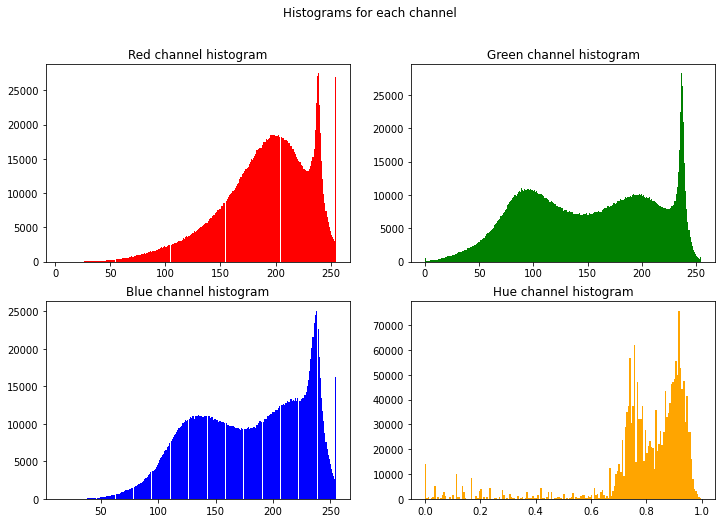

In [3]:
# Convert image to HSV color space
adeno_hsv = skimage.color.rgb2hsv(adeno_img)

# Extract hue channel
adeno_hue = adeno_hsv[:, :, 0]

# Display histograms for each channel
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].hist(adeno_img[:, :, 0].ravel(), bins=256, color='r')
ax[0, 0].set_title('Red channel histogram')

ax[0, 1].hist(adeno_img[:, :, 1].ravel(), bins=256, color='g')
ax[0, 1].set_title('Green channel histogram')

ax[1, 0].hist(adeno_img[:, :, 2].ravel(), bins=256, color='b')
ax[1, 0].set_title('Blue channel histogram')

ax[1, 1].hist(adeno_hue.ravel(), bins=180, color='orange')
ax[1, 1].set_title('Hue channel histogram')

plt.suptitle("Histograms for each channel")
plt.show()

#### 1.2.2 Apply Thresholding (2 pts)

For each histogram find the threshold(s) that work the best to isolate the mucinous area. Display the image after thresholding of each channel as well as the error between your prediction ($im$) and the annotations ($gt$) using the formula:

$$error = 1 - \left( \frac{1}{IJ} \sum_{i,j} im_{i,j} == gt_{i, j} \right)$$

Here, I and J are the dimension of the image.

In [4]:
from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu, threshold_multiotsu


def compute_error(msk, gt):
    return (1 - np.mean(msk == gt)).round(4)


# Convert RGB to HSV
hsv_image = rgb2hsv(adeno_img)
hue = hsv_image[:, :, 0]  # 0-1
red = adeno_img[:, :, 0]  # 0-255
green = adeno_img[:, :, 1]  # 0-255
blue = adeno_img[:, :, 2]  # 0-255

# # TODO: Maybe we can find non-binary thresholds (using `threshold_multiotsu`)? But not sure if it outperforms binary thresholding
#
# # Below are the thresholds generated by the Otsu method
# red_threshold = threshold_otsu(red)  # 181
# green_threshold = threshold_otsu(green)  # 150
# blue_threshold = threshold_otsu(blue)  # 175
# hue_threshold = threshold_otsu(hue)  # 0.5130603608630953
#
# # Apply thresholding
# mask_red = red > red_threshold
# mask_green = green > green_threshold
# mask_blue = blue > blue_threshold
# mask_hue = hue > hue_threshold
# mask_otsu = mask_red & mask_green & mask_blue & mask_hue
# # TODO: Is it necessary to apply a mask on the hue channel? It seems to work better without it
#
# # Compute error
# error_otsu = compute_error(mask_otsu, adeno_gt)
# print("Error Otsu: {}".format(error_otsu))
#
# # # Now, fine tune the thresholds
# # for r in range(125, 141):
# #     for g in range(145, 146):
# #         for b in range(150, 151):
# #             for h in range(0, 200):
# #
# #                 mask_red = red > r
# #                 mask_green = green > g
# #                 mask_blue = blue > b
# #                 mask_hue = hue > h / 1000
# #                 mask = mask_red & mask_green & mask_blue & mask_hue
# #                 error = compute_error(mask, adeno_gt)
# #                 if error < error_otsu:
# #                     error_otsu = error
# #                     red_threshold = r
# #                     green_threshold = g
# #                     blue_threshold = b
# #                     hue_threshold = h / 1000
# #
# #                     print("Red threshold: {}".format(red_threshold))
# #                     print("Green threshold: {}".format(green_threshold))
# #                     print("Blue threshold: {}".format(blue_threshold))
# #                     print("Hue threshold: {}".format(hue_threshold))
# #                     print("Error: {}".format(error_otsu))
# # print("Error: {}".format(error_otsu))
# # print("Red threshold: {}".format(red_threshold))
# # print("Green threshold: {}".format(green_threshold))
# # print("Blue threshold: {}".format(blue_threshold))
# # print("Hue threshold: {}".format(hue_threshold))
#
# # Below are the best thresholds found
# red_threshold = 126
# green_threshold = 145
# blue_threshold = 150
# hue_threshold = 0.033
#
# # Apply thresholding
# mask_red = red > red_threshold
# mask_green = green > green_threshold
# mask_blue = blue > blue_threshold
# mask_hue = hue > hue_threshold
# mask_found = mask_red & mask_green & mask_blue & mask_hue
#
# # Compute error
# error = compute_error(mask_found, adeno_gt)
# print("Error found: {}".format(error))


Best thresholds and errors for each channel:
{'red': {'threshold': 193, 'error': 0.448}, 'green': {'threshold': 145, 'error': 0.2621}, 'blue': {'threshold': 176, 'error': 0.2738}, 'hue': {'threshold': 0.8352941176470589, 'error': 0.1991}}


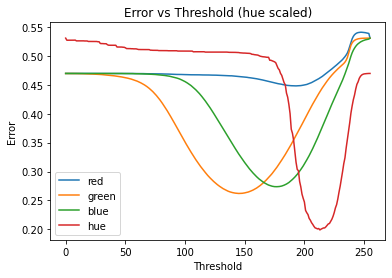

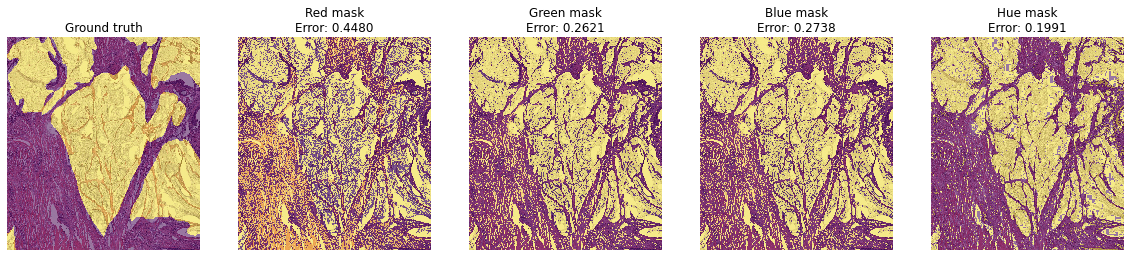

In [5]:
# For each channel, traverse the histogram and find the best threshold,
#   compute the error, record the error for each threshold, and generate a whole line chart
# For r, g, b, we take values greater than the threshold; for h, we take values less than the threshold
# Because we found that the mucinous area is darker than the rest of the image

import pandas as pd  # For plotting

best_configs = {'red': {'threshold': 0, 'error': 1}, 'green': {'threshold': 0, 'error': 1},
                'blue': {'threshold': 0, 'error': 1}, 'hue': {'threshold': 0, 'error': 1}}

# First, find the best threshold for r, g, b
red_errors = []
green_errors = []
blue_errors = []
for r in range(0, 256):
    mask_red = red > r
    error = compute_error(mask_red, adeno_gt)
    red_errors.append(error)
    if error < best_configs['red']['error']:
        best_configs['red']['threshold'] = r
        best_configs['red']['error'] = error

for g in range(0, 256):
    mask_green = green > g
    error = compute_error(mask_green, adeno_gt)
    green_errors.append(error)
    if error < best_configs['green']['error']:
        best_configs['green']['threshold'] = g
        best_configs['green']['error'] = error

for b in range(0, 256):
    mask_blue = blue > b
    error = compute_error(mask_blue, adeno_gt)
    blue_errors.append(error)
    if error < best_configs['blue']['error']:
        best_configs['blue']['threshold'] = b
        best_configs['blue']['error'] = error

# Then, find the best threshold for h
hue_errors = []
for h in range(0, 256):
    mask_hue = hue < h / 255
    error = compute_error(mask_hue, adeno_gt)
    hue_errors.append(error)
    if error < best_configs['hue']['error']:
        best_configs['hue']['threshold'] = h / 255
        best_configs['hue']['error'] = error

# Combine the errors and draw the line chart
df = pd.DataFrame({'red': red_errors, 'green': green_errors, 'blue': blue_errors, 'hue': hue_errors})
# Edit the title and axis labels, mention in the title that hue is scaled to 0-1
df.plot(title='Error vs Threshold (hue scaled)', xlabel='Threshold', ylabel='Error')

# Print the best thresholds and errors for each channel
print("Best thresholds and errors for each channel:")
print(best_configs)


# Apply each channel's best threshold, and plot each channel's mask, and the ground truth
mask_red = red > best_configs['red']['threshold']
mask_green = green > best_configs['green']['threshold']
mask_blue = blue > best_configs['blue']['threshold']
mask_hue = hue < best_configs['hue']['threshold']

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[0].set_title('Ground truth'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(mask_red, alpha=0.5, interpolation='nearest')
ax[1].set_title('Red mask\nError: {:.4f}'.format(best_configs['red']['error']))
ax[1].axis('off')

ax[2].imshow(adeno_img, interpolation='nearest')
ax[2].imshow(mask_green, alpha=0.5, interpolation='nearest')
ax[2].set_title('Green mask\nError: {:.4f}'.format(best_configs['green']['error']))
ax[2].axis('off')

ax[3].imshow(adeno_img, interpolation='nearest')
ax[3].imshow(mask_blue, alpha=0.5, interpolation='nearest')
ax[3].set_title('Blue mask\nError: {:.4f}'.format(best_configs['blue']['error']))
ax[3].axis('off')

ax[4].imshow(adeno_img, interpolation='nearest')
ax[4].imshow(mask_hue, alpha=0.5, interpolation='nearest')
ax[4].set_title('Hue mask\nError: {:.4f}'.format(best_configs['hue']['error']))
ax[4].axis('off')

plt.show()


#### 1.2.3 Best Thresholding (1 pts)

Based on your previous findings, set the best threshold(s) and create the final mask as the variable `mask_thesholding`

In [6]:
# TODO: replace variable with your own threshold
mask_thresholding = mask_hue

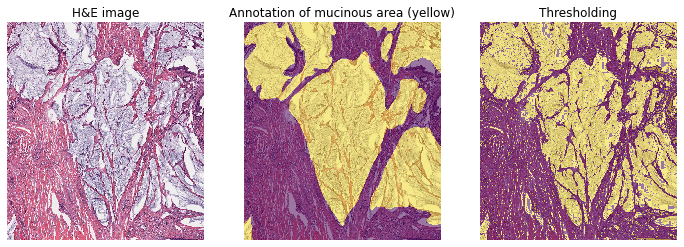

In [7]:
# Display MRI image
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Plot image
ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].set_title('H&E image'.format(im_h, im_w))
ax[0].axis('off')

ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[1].set_title('Annotation of mucinous area (yellow)')
ax[1].axis('off')

ax[2].imshow(adeno_img, interpolation='nearest')
ax[2].imshow(mask_thresholding, alpha=0.5, interpolation='nearest')
ax[2].set_title('Thresholding')
ax[2].axis('off')

plt.show()

---

### 1.3 Morphology (5pts)

To proceed, use the best results of the previous model (namely `mask_thesholding`) as the starting point. In this exercise we will try to clean the mask using morphology.

* A (2pts): Try the following operation [closing](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.closing), [opening](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.opening) with [disk](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk) size of: $1, 2, 5, 10$. Comment on the quality of the results.

* B (2pts): Try the following operation [remove_small_holes](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_holes), [remove_small_objects](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.remove_small_objects) with size of: $10, 50, 100, 500$. Comment on the quality of the results.

* C (1pts): Based on your previous results, can you find a combination of the functions that improve your results? Plot the best result along with the error rate. **Save the mask as the variable `mask_morph`**

#### 1.3.1 Morphology with Closing and Opening

Original error: 0.1991


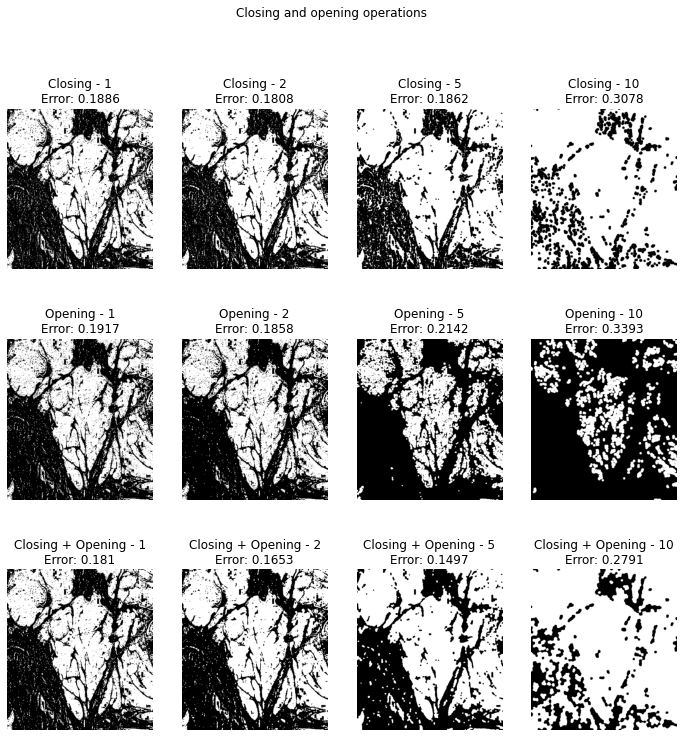

Best error: 0.1497
Best config: {'disk_size': 5, 'closing': True, 'opening': True, 'error': 0.1497}


In [8]:
# A: Closing and opening

from skimage.morphology import disk, closing, opening

fig, ax = plt.subplots(3, 4, figsize=(12, 12))
plt.suptitle("Closing and opening operations")

# Define initial variables
mask_morph = mask_thresholding.copy()
error_morph = compute_error(mask_morph, adeno_gt)

# Define the best configuration so far
best_config_A = {"disk_size": 1, "closing": True, "opening": True, "error": error_morph}
best_mask_A = mask_morph.copy()

# Define the list of disk sizes to try
disk_sizes = [1, 2, 5, 10]

# Print original error
print("Original error:", error_morph)

# Iterate over the disk sizes and perform opening and closing operations
for i, disk_size in enumerate(disk_sizes):
    # Perform closing and opening operations
    closed = closing(mask_morph, selem=disk(disk_size))
    opened = opening(mask_morph, selem=disk(disk_size))
    closed_opened = opening(closing(mask_morph, selem=disk(disk_size)), selem=disk(disk_size))

    ax[0, i].imshow(closed, cmap='gray')
    ax[0, i].set_title('Closing - {}\nError: {}'.format(disk_size, compute_error(closed, adeno_gt)))
    ax[0, i].axis('off')

    ax[1, i].imshow(opened, cmap='gray')
    ax[1, i].set_title('Opening - {}\nError: {}'.format(disk_size, compute_error(opened, adeno_gt)))
    ax[1, i].axis('off')

    ax[2, i].imshow(closed_opened, cmap='gray')
    ax[2, i].set_title('Closing + Opening - {}\nError: {}'.format(disk_size, compute_error(closed_opened, adeno_gt)))
    ax[2, i].axis('off')

    # Iterate over the masks and calculate errors
    for j, mask in enumerate([closed, opened, closed_opened]):
        error = compute_error(mask, adeno_gt)

        # Update the best configuration if the error is smaller
        if error < best_config_A["error"]:
            best_config_A = {"disk_size": disk_size, "closing": j != 1, "opening": j != 0, "error": error}
            best_mask_A = mask

plt.show()

# Print the best error and configuration
print("Best error: {}".format(best_config_A["error"]))
print("Best config: {}".format(best_config_A))

# Update the morphological mask
mask_morph_A = best_mask_A.copy()

##### Comments on the quality of the results

We can see from the above figure that both closing and opening operations can be helpful in smoothing and filling the gaps in the mask.
We can observe that as we increase the size of the disk, the mask becomes smoother,
but at the same time it may fill more holes, which can be either good or bad depending on the desired output.

#### 1.3.2 Morphology with Removing Small Holes and Objects

Original error: 0.1991
Best error: 0.1382
Best config: {'size': 500, 'holes': True, 'objects': True, 'error': 0.1382}


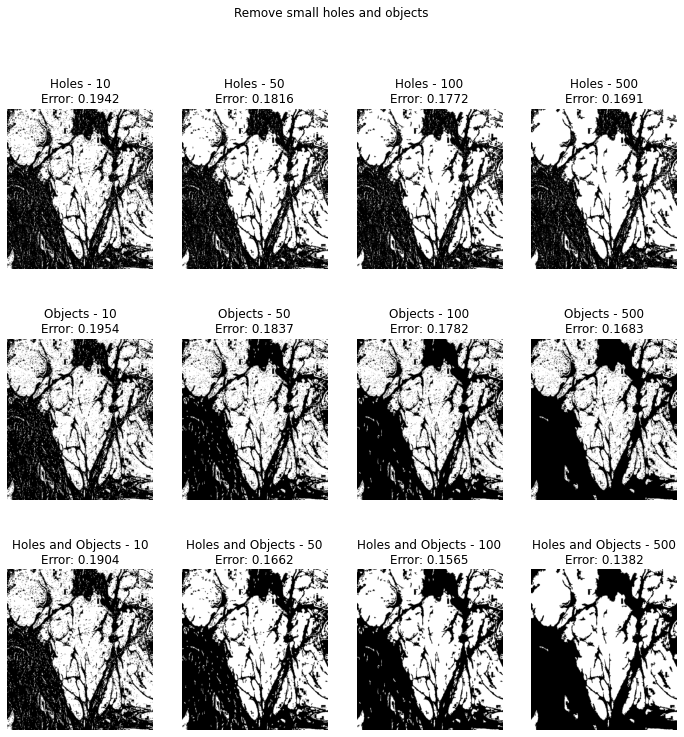

In [9]:
# B: Remove small holes and objects

from skimage.morphology import remove_small_holes, remove_small_objects

# Define initial variables
mask_morph = mask_morph.copy()
error_morph = compute_error(mask_morph, adeno_gt)

fig, ax = plt.subplots(3, 4, figsize=(12, 12))
plt.suptitle("Remove small holes and objects")

# Define the best configuration so far
best_config_B = {"size": 10, "error": error_morph}
best_mask_B = mask_morph.copy()

# Define the list of sizes to try
sizes = [10, 50, 100, 500]

# Print original error
print("Original error:", error_morph)

# Iterate over the sizes and perform hole and object removal operations
for i, size in enumerate(sizes):
    # Perform hole and object removal operations
    holes = remove_small_holes(mask_morph, area_threshold=size)
    objects = remove_small_objects(mask_morph, min_size=size)
    holes_objects = remove_small_objects(remove_small_holes(mask_morph, area_threshold=size), min_size=size)

    ax[0, i].imshow(holes, cmap='gray')
    ax[0, i].set_title('Holes - {}\nError: {}'.format(size, compute_error(holes, adeno_gt)))
    ax[0, i].axis('off')

    ax[1, i].imshow(objects, cmap='gray')
    ax[1, i].set_title('Objects - {}\nError: {}'.format(size, compute_error(objects, adeno_gt)))
    ax[1, i].axis('off')

    ax[2, i].imshow(holes_objects, cmap='gray')
    ax[2, i].set_title('Holes and Objects - {}\nError: {}'.format(size, compute_error(holes_objects, adeno_gt)))
    ax[2, i].axis('off')

    # Iterate over the masks and calculate errors
    for k, mask in enumerate([holes, objects, holes_objects]):
        error = compute_error(mask, adeno_gt)

        # Update the best configuration if the error is smaller
        if error < best_config_B["error"]:
            best_config_B = {"size": size, "holes": k != 1, "objects": k != 0, "error": error}
            best_mask_B = mask

# Print the best error and configuration
print("Best error: {}".format(best_config_B["error"]))
print("Best config: {}".format(best_config_B))

# Update the morphological mask
mask_morph_B = best_mask_B.copy()


##### Comments on the quality of the results

We can see from the above figure that removing small holes and objects can be helpful in removing noise from the mask.
When we increase the size of the holes and objects to be removed, the mask becomes smoother;
larger values for size result in a more accurate mask, as smaller values may remove parts of the mucinous area.
We can observe that `remove_small_objects` generally gives better results than `remove_small_holes`,
but it would be better if we could combine the two operations.


#### 1.3.3 Morphology with Closing + Opening and Removing Small Holes and Objects

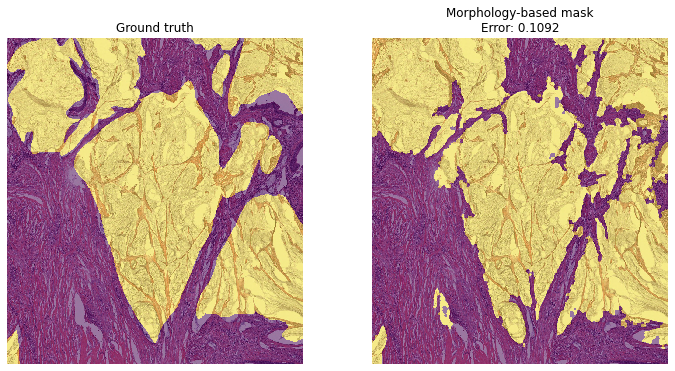

In [10]:
# TODO: Find the best conbinations of closing + opening and removing small holes and objects

# Best A: {'disk_size': 5, 'closing': True, 'opening': True, 'error': 0.1497}
# Best B: {'size': 500, 'holes': True, 'objects': True, 'error': 0.1382}

# C: Combine the functions to improve the results
selem = disk(5)
closed_img = closing(mask_thresholding, selem)
opened_img = opening(closed_img, selem)
mask_morph = remove_small_objects(remove_small_holes(opened_img, area_threshold=5000), min_size=5000)  #??
mask_morph = remove_small_objects(remove_small_holes(mask_morph, area_threshold=5000), min_size=5000)
morph_error = compute_error(mask_morph, adeno_gt)

# Display the best result and its error
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(adeno_img, interpolation='nearest')
ax[0].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
ax[0].set_title('Ground truth')
ax[0].axis('off')

ax[1].imshow(adeno_img, interpolation='nearest')
ax[1].imshow(mask_morph, alpha=0.5, interpolation='nearest')
ax[1].set_title('Morphology-based mask\nError: {:.4f}'.format(morph_error))
ax[1].axis('off')

plt.show()

---
### 1.4 Region growing (5pts)

In this exercise you will implement from scratch your own region growing algorithm. Choose one of the image channel (R/G/B/H) as the source image. You can use multiple seed point to achieve better results. Plot the best result along with the error rate. Save the mask as the variable `mask_region`.

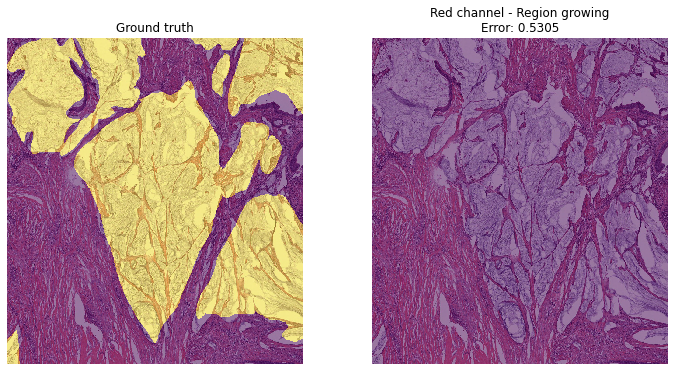

/Users/rizhong/opt/anaconda3/envs/iapr/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in ubyte_scalars


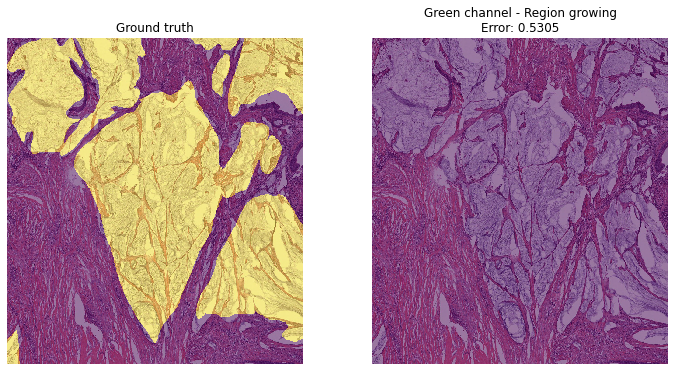

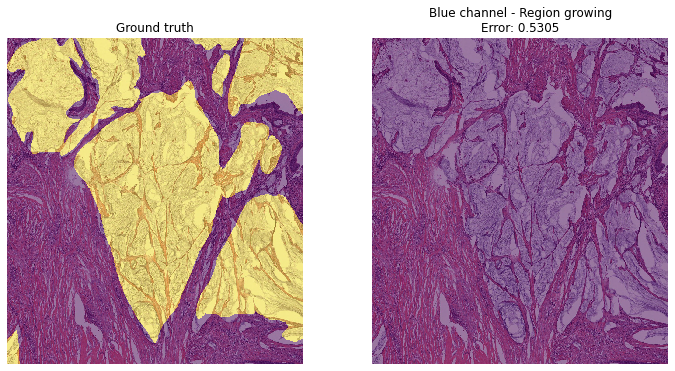

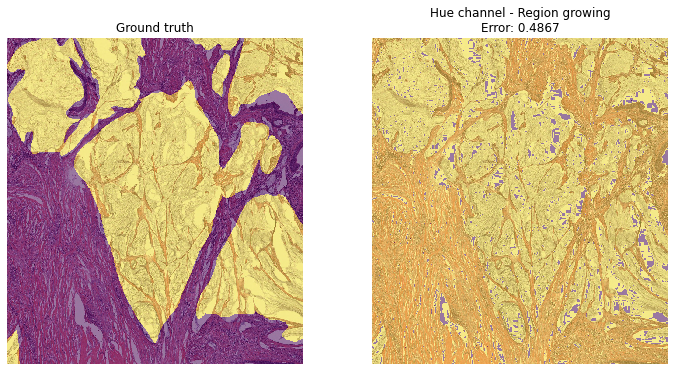

In [42]:
import numpy as np
from collections import deque
from skimage.color import rgb2gray

# Define a region-growing function
def region_growing(img, seed_points, threshold):
    h, w = img.shape
    visited = np.zeros((h, w), dtype=bool)
    region_mask = np.zeros((h, w), dtype=bool)

    queue = deque(seed_points)

    while queue:
        x, y = queue.popleft()

        if visited[y, x]:
            continue

        visited[y, x] = True
        region_mask[y, x] = True

        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx, ny = x + dx, y + dy

                if nx < 0 or nx >= w or ny < 0 or ny >= h:
                    continue

                if not visited[ny, nx] and abs(img[ny, nx] - img[y, x]) < threshold:
                    queue.append((nx, ny))

    return region_mask

# Apply the region-growing algorithm to each channel (R, G, B, and H)
channels = [('red', red), ('green', green), ('blue', blue), ('hue', hue)]
threshold = 0.1
seed_points = [(im_h // 2, im_w // 2)]  # Center seed point
masks = []

for name, channel in channels:
    mask_region = region_growing(channel, seed_points, threshold)
    masks.append(mask_region)
    error = compute_error(mask_region, adeno_gt)

    # Plot the result and error rate for each channel
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(adeno_img, interpolation='nearest')
    ax[0].imshow(adeno_gt, alpha=0.5, interpolation='nearest')
    ax[0].set_title('Ground truth')
    ax[0].axis('off')

    ax[1].imshow(adeno_img, interpolation='nearest')
    ax[1].imshow(mask_region, alpha=0.5, interpolation='nearest')
    ax[1].set_title('{} channel - Region growing\nError: {:.4f}'.format(name.capitalize(), error))
    ax[1].axis('off')

    plt.show()

# Determine the best mask and save it as `mask_region`
best_channel_index = np.argmin([compute_error(mask, adeno_gt) for mask in masks])
mask_region = masks[best_channel_index]


---
### 1.5 Method comparison (1pt)

In this section we display the overall outputs. Please make sure that you create the variables `mask_thesholding`, `mask_morph`, and `mask_region` to properly display the output. Comment on the results and what you think would be the best approach.

Blah blah blah

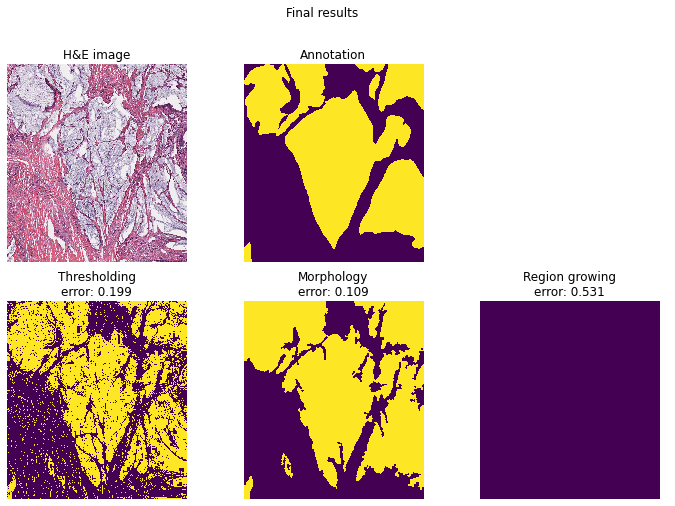

In [12]:
error_th = 1 - (mask_thresholding == adeno_gt).mean()
error_morph = 1 - (mask_morph == adeno_gt).mean()
error_region = 1 - (mask_region == adeno_gt).mean()

# Display MRI image
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Plot image
ax[0, 0].imshow(adeno_img, interpolation='nearest')
ax[0, 0].set_title('H&E image'.format(im_h, im_w))

# Plot image with overlay
ax[0, 1].imshow(adeno_gt, interpolation='nearest')
ax[0, 1].set_title('Annotation')

# Plot estimation using thresholding
ax[1, 0].imshow(mask_thresholding, interpolation='nearest')
ax[1, 0].set_title('Thresholding\nerror: {:.3f}'.format(error_th))

# Plot estimation using Contour detection
ax[1, 1].imshow(mask_morph, interpolation='nearest')
ax[1, 1].set_title('Morphology\nerror: {:.3f}'.format(error_morph))

# Plot estimation using Region growing
ax[1, 2].imshow(mask_region, interpolation='nearest')
ax[1, 2].set_title('Region growing\nerror: {:.3f}'.format(error_region))

[a.axis('off') for a in ax.ravel()]

plt.suptitle("Final results")
plt.show()

# ---
## Part 2: Axon segmentations (10 points)

#### Intro 

Axon segmentation is vital to neuroscience research as it enables the study of neurons' morphology and connectivity. We will conduct two exercises to evaluate the impact of your segmentation algorithms under different independent artefacts. Each exercise consists of a synthetic **Ground Truth (GT)** and two more images simulating a specific artifact.

The **Ground Truth**  has tree main compartments. 1) The inner part of the axon. 2) The outer layer of the axon (called myelin) and the extracellular slace (the background of the image). 

The task consists into segmenting the three main compartments in the image to compute the inner-axon and outer-axon radii distribution.


To compute the radii, we suggest the following approximation.
$$\hat{r}_{I}= \sqrt{\frac{A_{yellow}}{\pi}}$$
$$\hat{r}_{O}= \sqrt{\frac{A_{yellow} + A_{blue}}{\pi}}$$
Where **A** is the corresponding area of the comparments. 
**Using this image as reference** 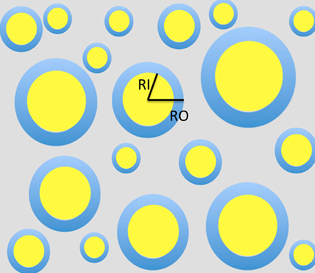

#### Artifacts simulated:

Excercise 1) Two images with different levels of SNR (signal to noise ratio). The images have rician noise.
Exercise  2) Two images adquired using a fraction of the fourier space. Only Lowest frequency are used to reconstruct the image. (simulating fast aquisitions in MRI)

Ensure your algorithm works on the GT before you go to the test cases with artifacts. Apply any preprocessing needed to the image. The preprocessing can be different for each type of image.

### Tasks

For each exercise we ask to:

1) Segment the images with the following colors: blue the inner part of the axon, red the outer part of the axon (myelin) and white for the backround(example) 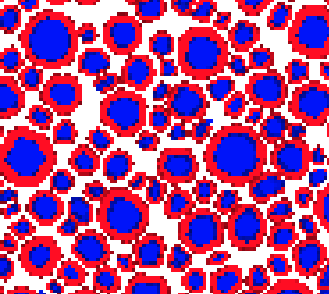

2) Count the number of axons obtained in the sample, calculate the radii for each axons, and display a radii histogram for the each of the images(GT and test cases).

In the exercises, assume that each pixel side is $(0.1 \mu m)$, i.e. a pixel has an area of $(0.01 \mu m^2 )$

## Grading 
The answers does not have to be perfect, they just be a good approximation.

1. Developing an algorithm that works for the two GT images. **(3 points)** 
2. Use preprosesing to prepare the images with SNR and the Low frequencies.  (**1 point** for SNR preprocesing , **1 point** for Low-frequency images preprocesing)
3. Running the algorithm in the test images. **1/2 point** SNR, **1/2 point** Low freqs
4. Computing and plotting radii distributions **(1 point)**
5. Explaining and discussing your implementation. **(3 points )**

Try to be specific, not necessarily long. In the discussion include:
 1. What worked? 
 2. What did not work?
 3. Why do you think it does not work? 
 4. How could you improve your algorithms as future work?  Try to avoid general comments like "using deep learning" 
 
**Extra points: Real data example (3 points), the algorithm should display a _good enough_ segmentation.**

### 2.1 SNR

In [13]:
data_base_path

'../data'

../data


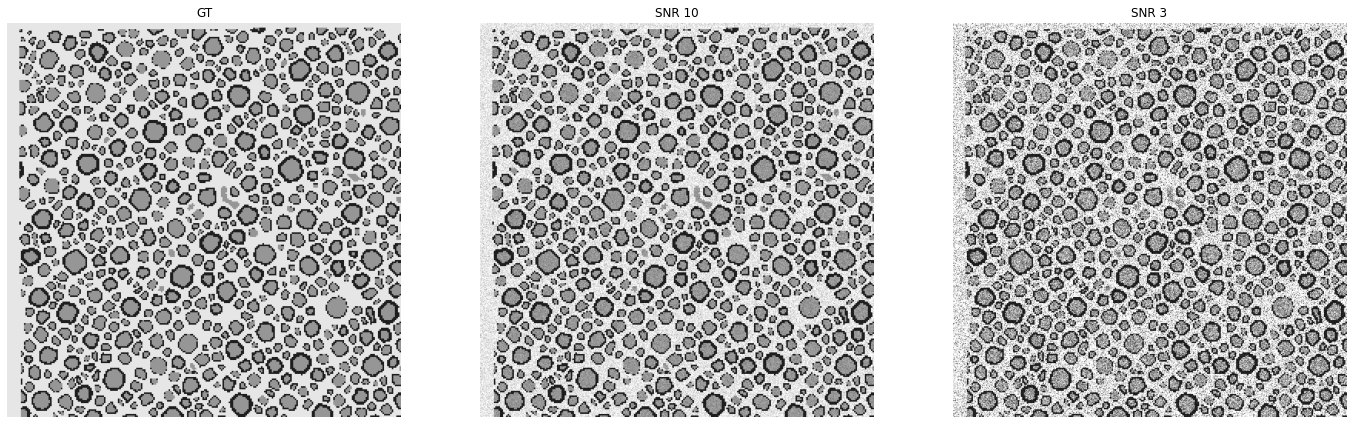

In [14]:
import cv2
import matplotlib.pyplot as plt

data_base_path = os.path.join(os.pardir, 'data')
print(data_base_path)
data_folder = 'lab-01-data'

path_folder = os.path.join(data_base_path, data_folder) + '/'

files = ["GT_0.png", "test_0_0.png", "test_0_1.png"]
gt_0 = cv2.imread(path_folder + files[0])
snr_10 = cv2.imread(path_folder + files[1])
snr_3 = cv2.imread(path_folder + files[2])

images = [gt_0, snr_10, snr_3]
im_names = ["GT", "SNR 10", "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512, 0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.1.1 Preprocessing 

 % add your images after preprocessing



### 2.1.2 Results Segmetations

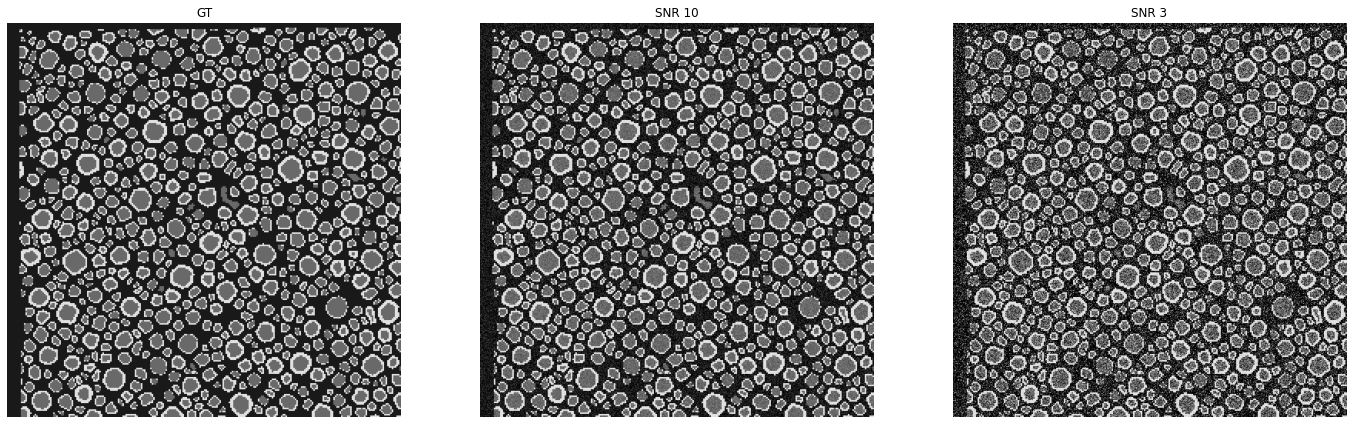

In [15]:
images = [gt_0, snr_10, snr_3]
im_names = ["GT", "SNR 10", "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(255 - im[0:512, 0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.1.3 Radii histrograms 

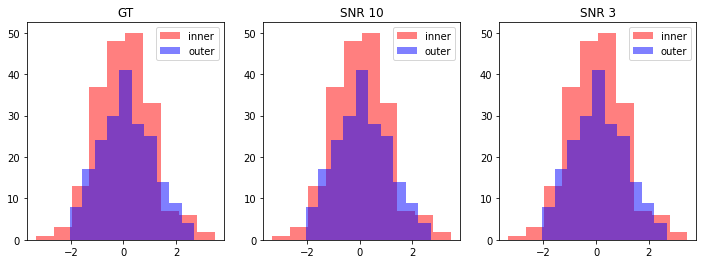

In [16]:
## results Radii distribution. proposal feel free to change it
import numpy as np

rads_outer = np.random.normal(0, 1, 200)
rads_inner = np.random.normal(0, 1, 200)

rads_gt = [rads_inner, rads_outer]
rads_test0 = [rads_inner, rads_outer]  # your result
rads_test1 = [rads_inner, rads_outer]  # your result

all_rads = [rads_gt, rads_test0, rads_test1]

images = [gt_0, snr_10, snr_3]
im_names = ["GT", "SNR 10", "SNR 3"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, rads, nm in zip(axes.ravel(), all_rads, im_names):
    ax.hist(rads[0], color="red", label="inner", alpha=0.5)
    ax.hist(rads[1], color="blue", label="outer", alpha=0.5)
    ax.legend()
    ax.set_title(nm)
plt.show()


### 2.2 Low frequencies

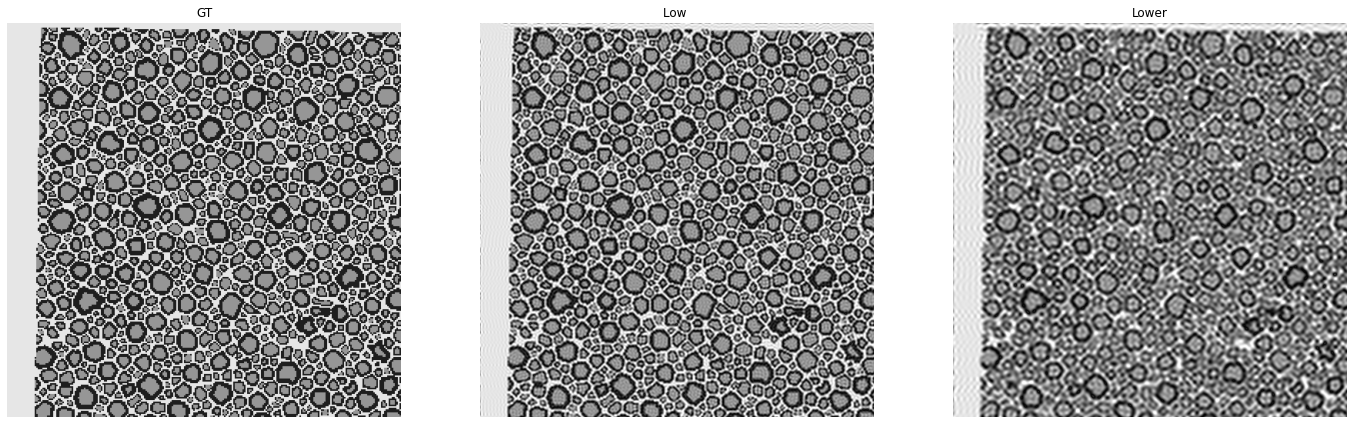

In [17]:

files = ["GT_3.png", "test_3_0.png", "test_3_1.png"]
path = "data/"
gt_3 = cv2.imread(path_folder + files[0])
lowfreq0 = cv2.imread(path_folder + files[1])
lowfreq1 = cv2.imread(path_folder + files[2])

images = [gt_3, lowfreq0, lowfreq1]
im_names = ["GT", "Low ", "Lower"]
fig, axes = plt.subplots(1, 3, figsize=(24, 24))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im[0:512, 0:512])
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2.1 Preprocessing

### 2.2.2 Results Segmetations

### 2.2.3 Radii histrograms


### 2.5 Not mandatory exercise, Real data ( 3 points )

The points are given just by having a good enough segmentation.

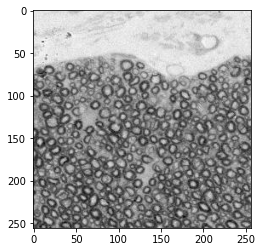

In [18]:
# Add your implementation and discussion
import cv2

files = ["extra_point.png"]
real_data = cv2.imread(path_folder + files[0])

plt.imshow(real_data[:256, :256])